<a href="https://colab.research.google.com/github/Kiro-tagama/DIO-BairesDev-Machine-Learning-Practitioner/blob/main/Treinamento_da_Rede_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição do Desafio


Projeto de criação de uma base de dados e treinamento da rede YOLO .

Seguindo os exemplos de aula, vamos rotular uma base de dados e aplicar o treinamento com a rede YOLO.

Para essa tarefa será necessário utilizar o software LabelMe: [link](http://labelme.csail.mit.edu/Release3.0/) para rotular as imagens.

Também será necessário utilizar a rede YOLO, disponível em: [link](https://pjreddie.com/darknet/yolo/).

Para quem preferir e não quiser rotular uma base de dados, pode usar as imagens já rotuladas do COCO: [link](https://cocodataset.org/#home).

E para quem estiver utilizando um computador que não consiga rodar a rede YOLO, pode utilizar o transfer learning no COLAB: [colab yolo](https://colab.research.google.com/drive/1lTGZsfMaGUpBG4inDIQwIJVW476ibXk_#scrollTo=j0t221djS1Gk).

O trabalho deve conter pelo menos duas classes retreinadas para detecção, além das classes já treinadas previamente antes de realizar o transfer learning.  


link do dio: [dio atividade](https://web.dio.me/lab/criacao-de-uma-base-de-dados-e-treinamento-da-rede-yolo/learning/7400ba5c-9fd7-42cd-aefe-131acfe198cb?back=/track/coding-the-future-baires-dev-machine-learning-practitioner)

estou usando o colab tpu q tem mais ram e disco se usar o normal refatore o que for necessario pois o o data set coco é meio grande

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def downloadDataSet(dataset):
  if not os.path.isdir(f"{dataset}2017"):
    !echo "download coco"
    !wget http://images.cocodataset.org/zips/{dataset}2017.zip
    !unzip {dataset}2017.zip

In [ ]:
# downloadDataSet("train")
downloadDataSet("val")
downloadDataSet("test")
# downloadDataSet("unlabeled")

## Treinamento com YOLO

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
#!wget https://developer.nvidia.com/compute/machine-learning/cudnn/secure/v7.5.0.56/prod/10.0_20190219/cudnn-10.0-linux-x64-v7.5.0.56.tgz

!unzip cudnn-10.0-linux-x64-v7.5.0.56.tgz -d /usr/local/
!sudo chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

unzip:  cannot find or open cudnn-10.0-linux-x64-v7.5.0.56.tgz, cudnn-10.0-linux-x64-v7.5.0.56.tgz.zip or cudnn-10.0-linux-x64-v7.5.0.56.tgz.ZIP.
chmod: cannot access '/usr/local/cuda/include/cudnn.h': No such file or directory
cat: /usr/local/cuda/include/cudnn.h: No such file or directory


In [ ]:
!git clone https://github.com/kriyeng/darknet/
%cd darknet

# Check the folder
!ls

Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
Receiving objects: 100% (10068/10068), 10.14 MiB | 1.03 MiB/s, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068 (from 1)
Resolving deltas: 100% (6715/6715), done.
/content/darknet
3rdparty      cfg		      darknet.py	include		       README.md
appveyor.yml  cmake		      darknet_video.py	json_mjpeg_streams.sh  scripts
build	      CMakeLists.txt	      data		LICENSE		       src
build.ps1     CMakeSettings.json      image_yolov2.sh	Makefile	       video_v2.sh
build.sh      DarknetConfig.cmake.in  image_yolov3.sh	net_cam_v3.sh	       video_yolov3.sh


In [ ]:
#download files
def imShow(path):

  print(f"Verificando se o arquivo existe: {os.path.exists(path)}")
  print(f"Permissões do arquivo: {oct(os.stat(path).st_mode)}")

  image = cv2.imread(path)

  if image is None:
    print(f"Error: Could not load image at path: {path}")
    return

  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()


# não sei a nessecidade desse download e upload

def upload():
  from google.colab import files
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

--2024-12-10 17:00:45--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  7.96MB/s    in 54s     

2024-12-10 17:01:39 (4.38 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

[Errno 2] No such file or directory: 'darknet'
/content/darknet
mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -c ./src/image_opencv.cpp -o obj/image_opencv.o
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘boo

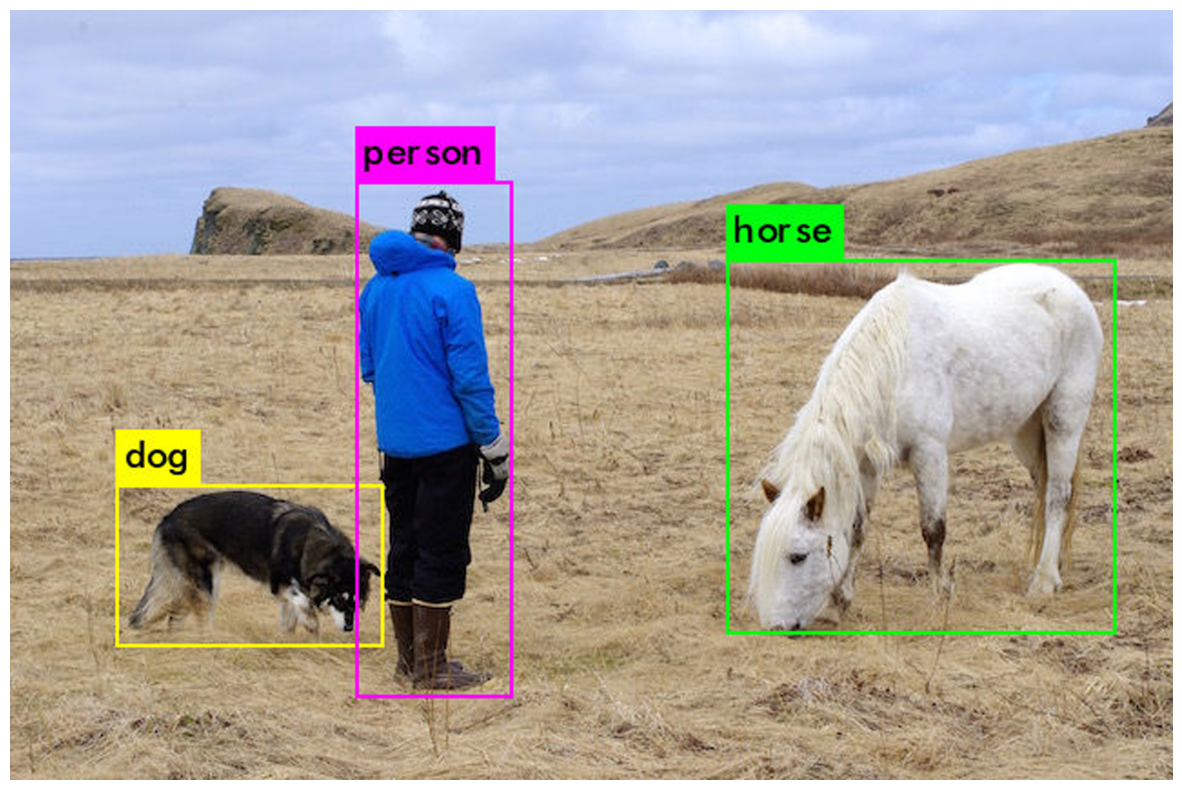

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

%cd darknet
!make

!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')

In [ ]:
def processimgwithouttraining(path):
  if not os.path.exists(path):
    print(f"Error: Could not load image at path: {path}")
    return

  %cd darknet
  !make
  !./darknet detect cfg/yolov3.cfg yolov3.weights {path} -dont-show
  imShow('predictions.jpg')

[Errno 20] Not a directory: 'darknet'
/content/darknet
chmod +x *.sh
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    12

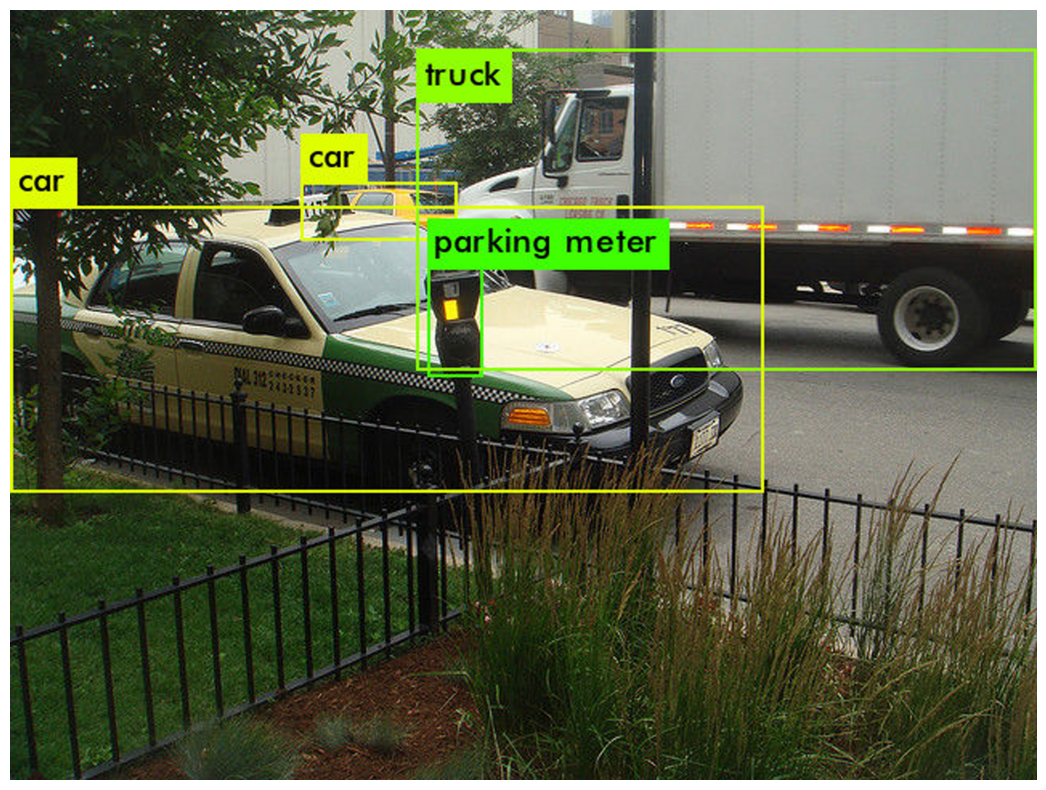

In [ ]:
processimgwithouttraining("/content/test2017/000000000001.jpg")

In [ ]:
!./darknet detector train "./darknet/obj.data" "./darknet/yolov3.cfg" "./darknet/darknet53.conv.74" -dont_show

Couldn't open file: ./darknet/obj.data
